In [120]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [79]:
df2 = pd.read_csv('data_final_lag.csv', parse_dates=['period'] ,sep=';')

In [80]:
df2 = df2.drop(['Unnamed: 0',], axis=1)
df2.rename(columns = {'totalAmount':'target'}, inplace = True)
df2['lit'] = 'A'

In [81]:
df = df2.copy()
df.drop(df.tail(1).index,inplace=True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   period         7 non-null      datetime64[ns]
 1   freq           7 non-null      int64         
 2   freqFinanced   7 non-null      int64         
 3   target         7 non-null      float64       
 4   meanAmount     7 non-null      float64       
 5   totalFinanced  7 non-null      float64       
 6   meanFinanced   7 non-null      float64       
 7   freqPayers     7 non-null      int64         
 8   freqReceiver   7 non-null      int64         
 9   lit            7 non-null      object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 688.0+ bytes


In [83]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df[['lit','period','target']],
    id_column='lit',
    timestamp_column="period",
)

In [84]:
train_data.loc['A']

,target
timestamp,
2021-11-01,35902.64
2021-12-01,268349.19
2022-01-01,753946.49
2022-02-01,7283045.52
2022-03-01,7100660.51
2022-04-01,5765920.25
2022-05-01,5042399.69


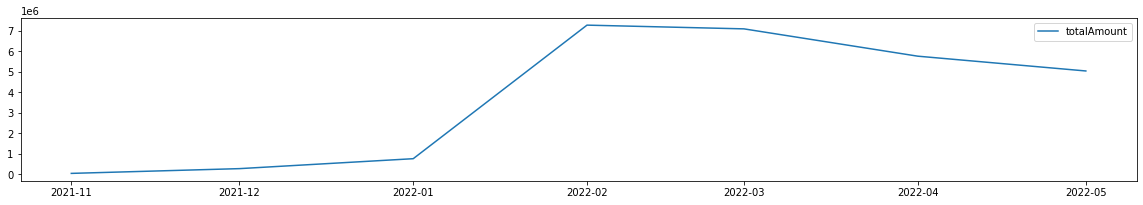

In [85]:
plt.figure(figsize=(20, 3))
for country in ["A"]:
    plt.plot(train_data.loc[country], label='totalAmount')
plt.legend()

In [86]:
prediction_length = 1

test_data = train_data.copy()  # the full data set

# the data set with the last prediction_length time steps included, i.e., akin to `a[:-5]`
train_data = train_data.slice_by_timestep(slice(None, -prediction_length))

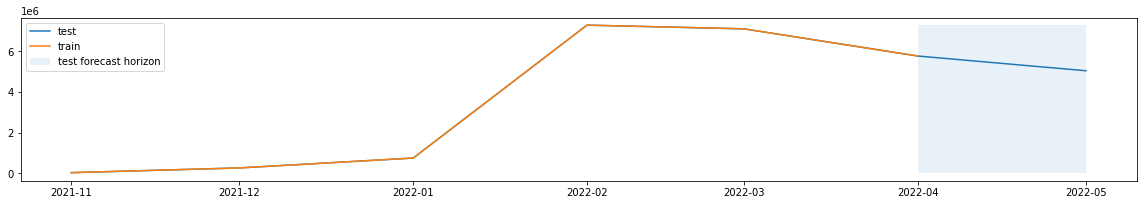

In [87]:
plt.figure(figsize=(20, 3))
plt.plot(test_data.loc['A'], label="test")
plt.plot(train_data.loc['A'], label="train")

test_range = (
    test_data.loc['A'].index.max(),
    train_data.loc['A'].index.max(),
)

plt.fill_betweenx(
    y=(0, test_data.loc['A']["target"].max()),
    x1=test_range[0],
    x2=test_range[1],
    alpha=0.1,
    label="test forecast horizon",
)

plt.legend()

In [88]:
predictor = TimeSeriesPredictor(
    path="autogluon-xepelinforecast",
    target="target",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor.fit(
    train_data=train_data,
    presets="low_quality",
)

Learner random seed set to 0
presets is set to low_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: low_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 1,
 'target_column': 'target',
 'time_limit': None}
Provided training data set with 6 rows, 1 items. Average time series length is 6.0.
Training artifacts will be saved to: /shared_folder/modelos/scoreComportamental/v1.3/class/Untitled Folder/autogluon-xepelinforecast
Validation data is None, will hold the last prediction_length 1 time steps out to use as validation set.
AutoGluon will save models to autogluon-xepelinforecast/

Starting training. Start time is 2022-08-26 16:35:09
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'ARIMA', 'Transformer']
Training timeseries model AutoETS. 
	'pandas._libs.tslibs.offsets.MonthBegin' object has no attribute

In [89]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.529615,-0.500896,0.037305,0.01843,0.004079,2
1,SimpleFeedForward,-0.627241,-0.272655,0.037374,0.01843,1.912636,1


In [90]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


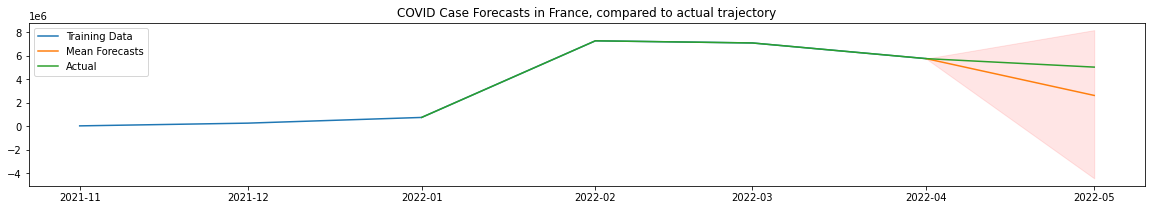

In [91]:
plt.figure(figsize=(20, 3))

ytrue = train_data.loc['A']["target"]
ypred = predictions.loc['A']

# prepend the last value of true range to predicted range for plotting continuity
ypred.loc[ytrue.index[-1]] = [ytrue[-1]] * 10
ypred = ypred.sort_index()

ytrue_test = test_data.loc['A']["target"][-5:]

plt.plot(ytrue[-30:], label="Training Data")
plt.plot(ypred["mean"], label="Mean Forecasts")
plt.plot(ytrue_test, label="Actual")

plt.fill_between(
    ypred.index, ypred["0.1"], ypred["0.9"], color="red", alpha=0.1
)
plt.title("COVID Case Forecasts in France, compared to actual trajectory")
_ = plt.legend()

In [92]:
pred_junio = predictor.predict(test_data)
pred_junio.rename(columns = {'mean':'target'}, inplace = True)

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


In [93]:
#pred_junio=pred_junio.droplevel(level=0)
pred_junio.iloc[:3,0].to_frame()

,,target
item_id,timestamp,
A,2022-06-01,2454701.5


In [94]:
pred = pd.concat([train_data, test_data, pred_junio.iloc[:3,0].to_frame()]).drop_duplicates()

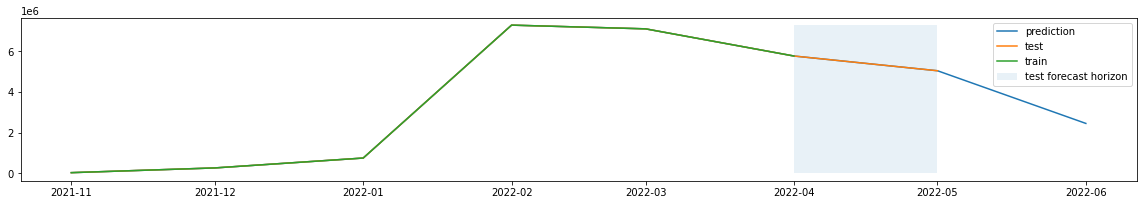

In [95]:
plt.figure(figsize=(20, 3))
plt.plot(pred.loc['A'], label="prediction")
plt.plot(test_data.loc['A'], label="test")
plt.plot(train_data.loc['A'], label="train")

test_range = (
    test_data.loc['A'].index.max(),
    train_data.loc['A'].index.max(),
    pred_junio.index.max()
)

plt.fill_betweenx(
    y=(0, test_data.loc['A']["target"].max()),
    x1=test_range[0],
    x2=test_range[1],
    alpha=0.1,
    label="test forecast horizon",
)

plt.legend()

In [96]:
df2

,period,freq,freqFinanced,target,meanAmount,totalFinanced,meanFinanced,freqPayers,freqReceiver,lit
0,2021-11-01,5,1,35902.64,7180.528000,10520.15,2104.030000,5,5,A
1,2021-12-01,13,8,268349.19,20642.245385,119352.51,9180.962308,13,12,A
2,2022-01-01,17,7,753946.49,44349.793529,592831.07,34872.415882,16,16,A
3,2022-02-01,107,43,7283045.52,68065.845981,5219511.13,48780.477850,83,56,A
4,2022-03-01,183,45,7100660.51,38801.423552,4485712.42,24512.089727,115,65,A
5,2022-04-01,225,49,5765920.25,25626.312222,2344379.98,10419.466578,137,68,A
6,2022-05-01,269,50,5042399.69,18744.980260,3057870.38,11367.547881,153,73,A
7,2022-06-01,73,18,1180788.62,16175.186575,714735.77,9790.900959,62,35,A


In [97]:
def process_metrics(y_true, y_pred):
    """Compute metrics based on model predictions.
    Args:
        - y_true: ground truth.
        - y_pred: prediction.
    Returns:
        - metrics: dictionary with all computed metrics.
    """
    metrics = {}

    metrics['MAE'] = mean_absolute_error(y_true,y_pred)
    metrics['MSE'] = mean_squared_error(y_true,y_pred)
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true,y_pred))
    metrics['RMSLogE'] = np.log(np.sqrt(mean_squared_error(y_true,y_pred)))
    metrics['r2'] = r2_score(y_true,y_pred)
   # metrics['r2Adjust'] = 1 - ((1-r2_score(y_test,y_pred))*(n-1)/(n-k-1))

    return metrics

In [124]:
y_true= pred.iloc[7:,:]
y_pred=df2.iloc[7:,3]
process_metrics(y_true, y_pred )

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'MAE': 1273912.88,
 'MSE': 1622854025829.894,
 'RMSE': 1273912.88,
 'RMSLogE': 14.057603729730493,
 'r2': nan}